## QAOA for Max-Cut


1. Define constraints with an arbitray graph :
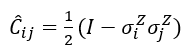

2. Define a Hamiltonian Cost function:
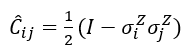

#### References:

     1. https://grove-docs.readthedocs.io/en/latest/qaoa.html
     2. https://github.com/rigetti/grove/blob/master/grove/pyqaoa/maxcut_qaoa.py#L89
     3. VQE Tutorial: https://github.com/DavitKhach/quantum-algorithms-tutorials
     


#### Acknowledgment: Many Thanks to Amy Brown of Rigetti for pointers to the grove and VQE repository.

### Notes and comments: The following code needs to be cleaned up and properly commented which I have been unable to do due to lack of time in meeting the deadline.


In [102]:
from pyquil import Program, get_qc
from pyquil.gates import *
import networkx as nx
import numpy as np
from pyquil.paulis import PauliTerm, PauliSum
from scipy.optimize import minimize
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H
from pyquil.paulis import sI, sX, sZ, exponentiate_commuting_pauli_sum
import pyquil.api as api
qvm_connection = api.QVMConnection()

In [106]:
# Test Connectivity to QVM

from pyquil.api import local_qvm

prog = Program(Z(0), CNOT(0, 1))

with local_qvm():
    results = qvm.run_and_measure(prog, trials=10)

In [107]:
# construct a Bell State program
p = Program(H(0), CNOT(0, 1))

In [108]:
# Test: run the program on a QVM
qc = get_qc('9q-square-qvm')
result = qc.run_and_measure(p, trials=10)
print(result[0])
print(result[1])

[0 1 1 1 1 1 1 1 0 0]
[0 1 1 1 1 1 1 1 0 0]


In [109]:
import itertools
from pyquil.quil import Program
from pyquil.paulis import sZ, sX, sI, exponential_map


In [110]:
# Create a 4-node array graph: 0-1-2-3.
graph = [(0, 1), (1, 2), (2, 3),(3,1)]
# Nodes [0, 1, 2, 3].
nodes = range(4)

In [111]:
# Create the initial state program, a sum over all bitstrings, via Hadamards on all qubits.
init_state_prog = Program([H(i) for i in nodes])


In [112]:
cost_ham = sum(0.5 * sZ(i) * sZ(j) - 0.5*sI(0) for i, j in graph)
driver_ham = sum(-1. * sX(i) for i in nodes)

In [113]:
def qaoa_ansatz(gammas, betas):
    """
    Function that returns a QAOA ansatz program for a list of angles betas and gammas. len(betas) ==
    len(gammas) == P for a QAOA program of order P.
    :param list(float) gammas: Angles over which to parameterize the cost Hamiltonian.
    :param list(float) betas: Angles over which to parameterize the driver Hamiltonian.
    :return: The QAOA ansatz program.
    :rtype: Program.
    """
    return Program(
        [
            exponentiate_commuting_pauli_sum(cost_ham)(g)
            + exponentiate_commuting_pauli_sum(driver_ham)(b)
            for g, b in zip(gammas, betas)
        ]
    )

In [114]:
# Create a program, the state initialization plus a QAOA ansatz program, for P = 2.
program = init_state_prog + qaoa_ansatz([0.0, 0.5], [0.75, 1.0])

In [115]:
# Initialize the QVM and run the program.
qc = get_qc("9q-generic-qvm")

results = qc.run_and_measure(program, trials=6)
print(results)

{0: array([1, 1, 0, 1, 0, 0]), 1: array([0, 1, 0, 0, 1, 0]), 2: array([0, 1, 0, 0, 1, 1]), 3: array([0, 1, 0, 0, 0, 0]), 4: array([0, 0, 0, 0, 0, 0]), 5: array([0, 0, 0, 0, 0, 0]), 6: array([0, 0, 0, 0, 0, 0]), 7: array([0, 0, 0, 0, 0, 0]), 8: array([0, 0, 0, 0, 0, 0])}
